
# IMPORTING THE LIBRERIES

In [1]:
import sagemaker
from sagemaker import get_execution_role

import numpy as np
import pandas as pd

import boto3
import re

print('Libraries_loaded')

Libraries_loaded


# Read Dataset from S3 Bucket

In [2]:
bucket_name = 'diabetes-prediction-dataset'#  bucket name 

#Folders to store traning and testing data.
train_data = r'diabetespred/training/'
val_data = r'diabetespred/validation/' 

s3_model_output_location = r's3://{0}/diabetespred/model'.format(bucket_name)
s3_training_file_location = r's3://{0}/{1}'.format(bucket_name,train_data)
s3_validation_file_location = r's3://{0}/{1}'.format(bucket_name,val_data)

In [3]:
print(s3_model_output_location)
print(s3_training_file_location)
print(s3_validation_file_location)

s3://diabetes-prediction-dataset/diabetespred/model
s3://diabetes-prediction-dataset/diabetespred/training/
s3://diabetes-prediction-dataset/diabetespred/validation/


In [4]:
#path where dataset is stored in s3 bucket.
data = 's3://diabetes-prediction-dataset/diabetespred/diabetes.csv' 

In [5]:
#reading .csv file from s3.
df = pd.read_csv(data)
df.shape

(768, 9)

In [7]:
#Attributes in the dataset.
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols

['Outcome',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [8]:
df = df[cols]
df.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6,148,72,35,0,33.6,0.627,50
1,0,1,85,66,29,0,26.6,0.351,31
2,1,8,183,64,0,0,23.3,0.672,32
3,0,1,89,66,23,94,28.1,0.167,21
4,1,0,137,40,35,168,43.1,2.288,33


# Data Analysis

In [9]:
#Checking mssing values
print('Number of null values in different columns are: ')
print('--------------------------------------------------')
print(df.isnull().sum())
print('--------------------------------------------------')

Number of null values in different columns are: 
--------------------------------------------------
Outcome                     0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64
--------------------------------------------------


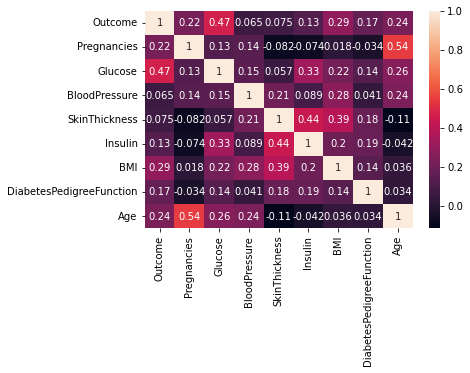

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.show()

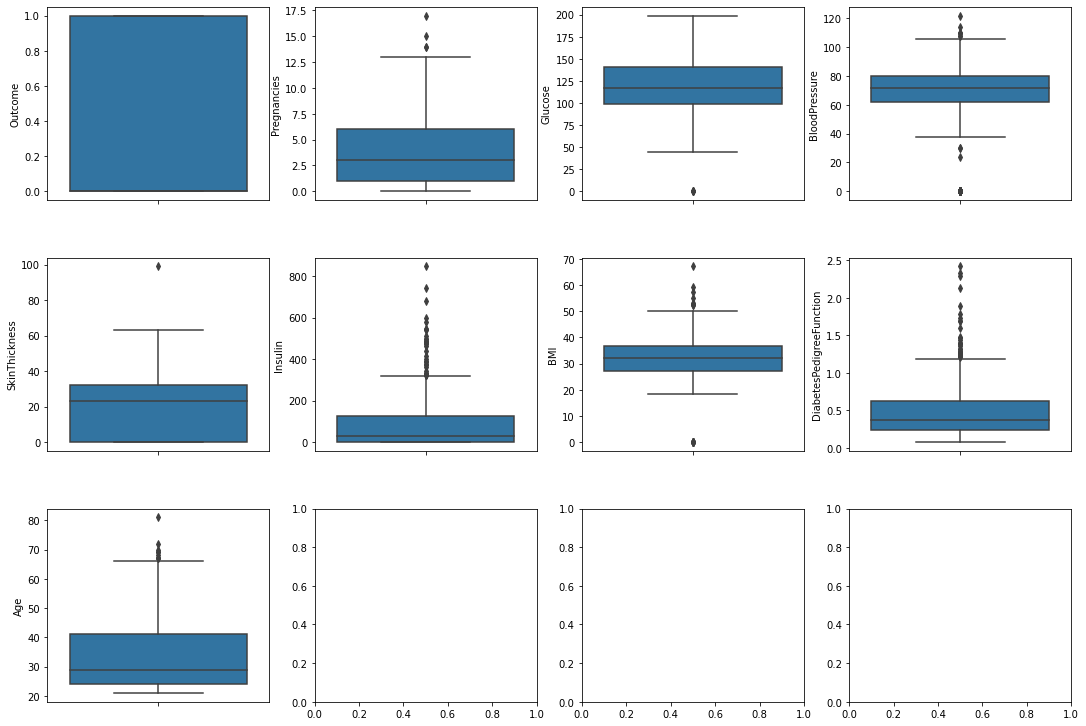

In [11]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.boxplot(y=k, data = df, ax = axs[index])     
    index += 1
plt.tight_layout(pad = 0.4, w_pad = 0.5, h_pad = 5.0)
plt.show()

In [12]:
df = df[~((df['Insulin'] >= 270.0))]
df = df[~((df['DiabetesPedigreeFunction'] >= 1.5))]

# Splitting training and testing dataset and storing it to S3 bucket

In [13]:
train = df[:629]
val = df[629:]

In [14]:
train.shape

(629, 9)

In [15]:
val.shape

(80, 9)

In [16]:
train.head()

,Outcome,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,6,148,72,35,0,33.6,0.627,50
1,0,1,85,66,29,0,26.6,0.351,31
2,1,8,183,64,0,0,23.3,0.672,32
3,0,1,89,66,23,94,28.1,0.167,21
5,0,5,116,74,0,0,25.6,0.201,30


In [17]:
np_train = train.values
np_val = val.values

In [18]:
type(np_train)

numpy.ndarray

In [19]:
#Save train and validation dataset as .csv file
np.savetxt("train.csv", np_train, delimiter=",")

In [20]:
np.savetxt("val.csv", np_val, delimiter=",")

In [21]:
#write train and validation dataset into S3 bucket
def write_to_s3(filename, bucket, key):
    with open(filename,'rb') as f: 
        return boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(f)

In [22]:
write_to_s3('train.csv', 
            bucket_name,
            train_data + 'train.csv')

write_to_s3('val.csv',
            bucket_name,
            val_data + 'val.csv')

# Train Xgboost model

In [23]:
sess = sagemaker.Session()

In [24]:
role = get_execution_role()
role

'arn:aws:iam::552538510360:role/service-role/AmazonSageMaker-ExecutionRole-20220714T130895'

In [25]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(
    sess.boto_region_name,
    "xgboost", 
    "latest")

print(' SageMaker XGBoost Info :\n{} ({})'.format(container, sess.boto_region_name))

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


 SageMaker XGBoost Info :
433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest (us-west-2)


In [26]:
estimator = sagemaker.estimator.Estimator(
    container,
    role, 
    instance_count=1, 
    instance_type='ml.m4.xlarge',
    output_path=s3_model_output_location,
    sagemaker_session=sess,
    base_job_name ='v1-xgboost-diabetes')

In [27]:
estimator.set_hyperparameters(max_depth=7,
                              objective="binary:logistic",num_round=1000)

In [28]:
estimator.hyperparameters()

{'max_depth': 7, 'objective': 'binary:logistic', 'num_round': 1000}

In [29]:
training_input_config = sagemaker.session.s3_input(
    s3_data = s3_training_file_location,
    content_type='csv',
    s3_data_type='S3Prefix')

validation_input_config = sagemaker.session.s3_input(
    s3_data=s3_validation_file_location,
    content_type='csv',
    s3_data_type='S3Prefix'
)

data_channels = {'train': training_input_config, 'validation': validation_input_config}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [30]:
print(training_input_config.config)
print(validation_input_config.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://diabetes-prediction-dataset/diabetespred/training/', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://diabetes-prediction-dataset/diabetespred/validation/', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}


In [31]:
estimator.fit(data_channels)

2022-07-30 02:46:34 Starting - Starting the training job...
2022-07-30 02:47:00 Starting - Preparing the instances for trainingProfilerReport-1659149194: InProgress
.........
2022-07-30 02:48:35 Downloading - Downloading input data...
2022-07-30 02:49:03 Training - Downloading the training image......
2022-07-30 02:49:58 Training - Training image download completed. Training in progress..Arguments: train
[2022-07-30:02:50:02:INFO] Running standalone xgboost training.
[2022-07-30:02:50:02:INFO] File size need to be processed in the node: 0.15mb. Available memory size in the node: 8827.01mb
[2022-07-30:02:50:02:INFO] Determined delimiter of CSV input is ','
[02:50:02] S3DistributionType set as FullyReplicated
[02:50:02] 629x8 matrix with 5032 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-07-30:02:50:02:INFO] Determined delimiter of CSV input is ','
[02:50:02] S3DistributionType set as FullyReplicated
[02:50:02] 80x8 matrix with 640 entries loade

# Deploy and Test the trained Xgboost model

In [40]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', endpoint_name = 'xgboostmodel3-endpoint')

In [41]:
from sagemaker.predictor import CSVSerializer, JSONDeserializer
predictor.serializer = sagemaker.serializers.CSVSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [42]:
sagemaker.serializers.CSVSerializer()

In [43]:
predictor.endpoint_name

'xgboostmodel2-endpoint'

The person with Pregnancies=0, Glucose=137, BloodPressure=40, SkinThickness=35, Insulin=168, BMI=43.1, DiabetesPedigreeFunction=2.288, Age=33, have diabetes or not.

In [44]:
data = [0,137,40,35,168,43.1,2.288,33]
result = predictor.predict(data)
np.round(float(result))

1.0

1.0 indicates that the person has diabetes. 

The person with Pregnancies=4, Glucose=110, BloodPressure=92, SkinThickness=0, Insulin=0, BMI=37.6, DiabetesPedigreeFunction=0.191, Age=30, have diabetes or not.

In [45]:
data = [4,110,92,0,0,37.6,0.191,30]
result = predictor.predict(data)
np.round(float(result))

0.0

   0.0 indicates that the person has no diabetes. 